In [82]:
import torch
import matplotlib.pyplot as plt
import os
from torch import nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset, Dataset

In [83]:
args = {
    'epoch_num': 5,      
    'lr': 1e-3,           
    'weight_decay': 8e-4, 
    'batch_size': 20,     
}

In [84]:
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(f'Using device: {args["device"]}')

Using device: cuda


In [85]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(root='./training_set/training_set', transform=data_transforms)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.ImageFolder(root='./test_set/test_set', transform=data_transforms)

test_loader = DataLoader(test_set, batch_size=64, shuffle=True) 


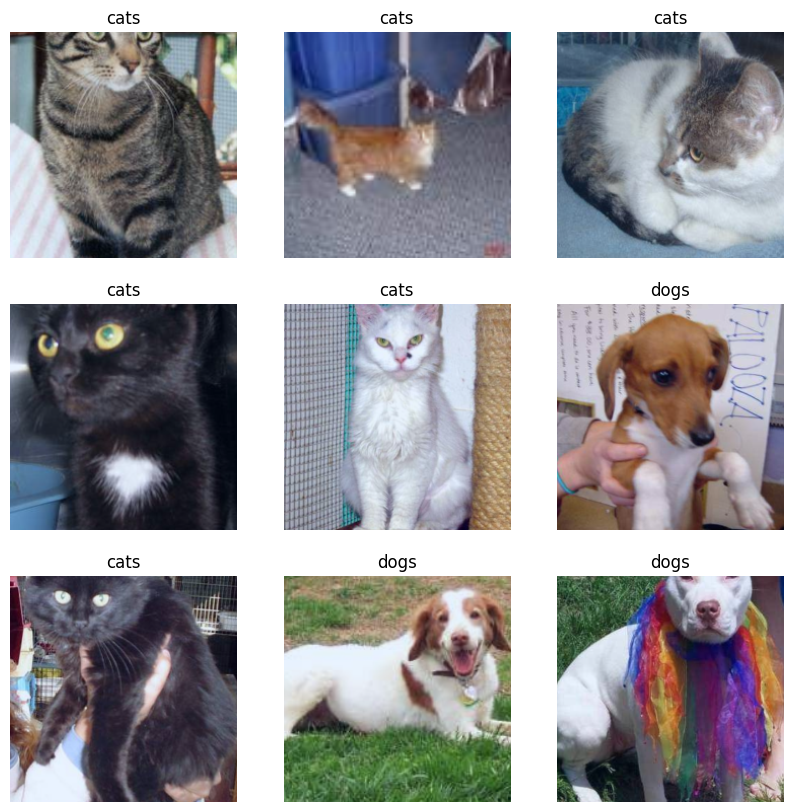

In [86]:

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, (images, labels) in enumerate(train_loader):
    if i >= 9: 
        break
    
    img = images[0].permute(1, 2, 0).numpy()  
    
    img = (img - img.min()) / (img.max() - img.min())  
    
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title(train_set.classes[labels[0]])
    ax[i // 3, i % 3].axis('off')

plt.show()

In [87]:
net = models.vgg16(pretrained=True).to(args['device'])
print(net)

c:\Users\breno\OneDrive\Documentos\GitHub\study-deeplearning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\breno\OneDrive\Documentos\GitHub\study-deeplearning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
print(list(net.classifier.named_children())[-1])

net.classifier = nn.Sequential(*list(net.classifier.children())[:-1])

print(list(net.classifier.named_children())[-1])

('6', Linear(in_features=4096, out_features=1000, bias=True))
('5', Dropout(p=0.5, inplace=False))


In [89]:
def extract_features(loader):
    net.eval()

    features = []
    labels = []

    with torch.no_grad():
        for k, (images, labels_batch) in enumerate(loader):
            image = images.to(args['device'])
            label = labels_batch.to(args['device'])

            characteristic = net(image)

            features.append(characteristic.detach().cpu())  
            labels.append(label.detach().cpu())  

    features = torch.cat(features)
    labels = torch.cat(labels)

    return features, labels

In [90]:
use_subset = False
num_samples = 2000  

if use_subset:

    train_indices = torch.randperm(len(train_set))[:num_samples]
    test_indices = torch.randperm(len(test_set))[:num_samples]

    train_subset = Subset(train_set, train_indices)
    test_subset = Subset(test_set, test_indices)

    train_loader_subset = DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=True)

    print("Usando subset com {} amostras.".format(num_samples))
else:

    train_loader_subset = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader_subset = DataLoader(test_set, batch_size=64, shuffle=True)

    print("Usando o conjunto completo.")

print('Extracting features from training set...')
train_features, train_labels = extract_features(train_loader_subset)

print('Extracting features from test set...')
test_features, test_labels = extract_features(test_loader_subset)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

print(train_features)
print(train_labels)

Usando o conjunto completo.
Extracting features from training set...
Extracting features from test set...
torch.Size([8005, 4096]) torch.Size([8005])
torch.Size([2023, 4096]) torch.Size([2023])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4846],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1358],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4412, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.2303, 0.0570, 0.0000]])
tensor([1, 1, 0,  ..., 1, 0, 1])


In [91]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(train_features, train_labels)

svc.score(test_features, test_labels)


0.9915966386554622